## Monolingual Named Entity Recognition (Stromberg NLP Twitter P.o.S. Dataset)

Dataset Source: https://huggingface.co/datasets/strombergnlp/twitter_pos_vcb

#### Import Necessary Libraries

In [1]:
import os, sys
from collections import Counter, defaultdict
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import datasets
from datasets import load_dataset, DatasetDict

import torch
from torch.nn.functional import cross_entropy

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import Trainer, TrainingArguments

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python :".rjust(18), sys.version[0:6])
print("NumPy :".rjust(18), np.__version__)
print("Pandas :".rjust(18), pd.__version__)
print("Torch :".rjust(18), torch.__version__)
print("Transformers :".rjust(18), transformers.__version__)
print("datasets :".rjust(18), datasets.__version__)
print("Sklearn :".rjust(18), sklearn.__version__)

          Python : 3.9.12
           NumPy : 1.24.3
          Pandas : 2.0.1
           Torch : 2.0.0
    Transformers : 4.28.1
        datasets : 2.11.0
         Sklearn : 1.2.2


#### Ingest English Subset of Dataset

In [3]:
data = load_dataset("strombergnlp/twitter_pos_vcb")

data

Found cached dataset twitter_pos_vcb (/Users/briandunn/.cache/huggingface/datasets/strombergnlp___twitter_pos_vcb/twitter-pos-vcb/1.0.0/2c671a933c7ffb84cf124a1f987cd73fb883e6b3628ee4a01f5326f5aefc296a)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags'],
        num_rows: 159492
    })
})

#### Split Dataset into DatasetDict

In [4]:
# Split Dataset into train/test/eval datasets
# then pack all of them into DatasetDict
train_testvalid = data['train'].train_test_split(test_size=0.25)
test_valid = train_testvalid['test'].train_test_split(test_size=0.80)

ds = DatasetDict({
    'train': train_testvalid['train'], 
    'test': test_valid['test'], 
    'eval': test_valid['train']})

print('Training data shape:', ds['train'].shape)
print('Testing data shape:', ds['test'].shape)
print('Validation data shape:', ds['eval'].shape)

Training data shape: (119619, 3)
Testing data shape: (31899, 3)
Validation data shape: (7974, 3)


#### Example

In [5]:
example = ds['train'][12]

example

{'id': '144607', 'tokens': ['#food'], 'pos_tags': [48]}

#### Display Feature Information About Each Feature

In [6]:
for k, v in ds["train"].features.items():
    print(f"{k}: \n{v}\n")

id: 
Value(dtype='string', id=None)

tokens: 
Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)

pos_tags: 
Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', 'RT', 'HT', 'USR', 'URL'], id=None), length=-1, id=None)



#### Define Tag Values & Conversions Between String & Integer Values

In [7]:
pos_tag_values = ds['train'].features[f'pos_tags'].feature.names
NUM_OF_LABELS = len(pos_tag_values)

label2id = {tag: idx for idx, tag in enumerate(pos_tag_values)}
id2label = {idx: tag for idx, tag in enumerate(pos_tag_values)}

print(f"List of tag values: \n{pos_tag_values}")
print(f"Number of NER Tags: \n{NUM_OF_LABELS}")
print(f"id2label: \n{id2label}")
print(f"label2id: \n{label2id}")

List of tag values: 
['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', 'RT', 'HT', 'USR', 'URL']
Number of NER Tags: 
51
id2label: 
{0: '"', 1: "''", 2: '#', 3: '$', 4: '(', 5: ')', 6: ',', 7: '.', 8: ':', 9: '``', 10: 'CC', 11: 'CD', 12: 'DT', 13: 'EX', 14: 'FW', 15: 'IN', 16: 'JJ', 17: 'JJR', 18: 'JJS', 19: 'LS', 20: 'MD', 21: 'NN', 22: 'NNP', 23: 'NNPS', 24: 'NNS', 25: 'NN|SYM', 26: 'PDT', 27: 'POS', 28: 'PRP', 29: 'PRP$', 30: 'RB', 31: 'RBR', 32: 'RBS', 33: 'RP', 34: 'SYM', 35: 'TO', 36: 'UH', 37: 'VB', 38: 'VBD', 39: 'VBG', 40: 'VBN', 41: 'VBP', 42: 'VBZ', 43: 'WDT', 44: 'WP', 45: 'WP$', 46: 'WRB', 47: 'RT', 48: 'HT', 49: 'USR', 50: 'URL'}
label2id: 
{'"': 0, "''": 1, '#': 2, '$': 3, '(': 4, ')': 5, ',': 6, '.': 7, ':': 8, '``': 9, 'C

#### Basic Values/Constants

In [8]:
MODEL_CKPT = "bert-base-cased"

MODEL_NAME = f"{MODEL_CKPT}-finetuned-Stromberg_NLP_Twitter-PoS_v2"
NUM_OF_EPOCHS = 2

BATCH_SIZE = 16
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
WEIGHT_DECAY = 0.01

LR = 2e-5
DEVICE = torch.device("cpu")

STEPS = 500

#### Function to Tokenize & Align Inputs

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize_and_align_labels(samples):
    tokenized_inputs = tokenizer(samples["tokens"], 
                                      truncation=True, 
                                      is_split_into_words=True)
    
    labels = []
    
    for idx, label in enumerate(samples[f"pos_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        prev_word_idx = None
        label_ids = []
        for word_idx in word_ids: # set special tokens to -100
            if word_idx is None or word_idx == prev_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            prev_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

#### Apply Above Function to Tokenize Dataset

In [10]:
encoded_ds = ds.map(tokenize_and_align_labels, 
                       batched=True, 
                       remove_columns=
                        [
                            'pos_tags', 
                            'tokens'
                        ]
                    )

Map:   0%|          | 0/119619 [00:00<?, ? examples/s]

Map:   0%|          | 0/31899 [00:00<?, ? examples/s]

Map:   0%|          | 0/7974 [00:00<?, ? examples/s]

#### Define Data Collator

In [11]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

#### Load Custom Model

In [12]:
model = (AutoModelForTokenClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id
    ).to(DEVICE))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

#### Create Compute Metrics Function

In [13]:
label_list = pos_tag_values

poseval = evaluate.load("poseval")

labels = [label_list[i] for i in example[f'pos_tags']]

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions, 
                            axis=2)
    
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = poseval.compute(predictions=true_predictions, 
                              references=true_labels)
    
    return results

#### Define TrainingArguments

In [14]:
args = TrainingArguments(
    MODEL_NAME,
    log_level="error",
    logging_first_step=True,
    learning_rate=LR,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy=STRATEGY,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    logging_steps=STEPS,
    weight_decay=WEIGHT_DECAY,
    save_strategy=STRATEGY,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [15]:
trainer = Trainer(model, 
                  args=args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer,
                  train_dataset=encoded_ds["train"],
                  eval_dataset=encoded_ds["test"]
                  )

Cloning https://huggingface.co/DunnBC22/bert-base-cased-finetuned-Stromberg_NLP_Twitter-PoS_v2 into local empty directory.


#### Train Model

In [16]:
train_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/14954 [00:00<?, ?it/s]

{'loss': 3.9571, 'learning_rate': 1.9998662565199947e-05, 'epoch': 0.0}
{'loss': 0.553, 'learning_rate': 1.9331282599973254e-05, 'epoch': 0.07}
{'loss': 0.1322, 'learning_rate': 1.8662565199946505e-05, 'epoch': 0.13}
{'loss': 0.111, 'learning_rate': 1.7993847799919754e-05, 'epoch': 0.2}
{'loss': 0.1017, 'learning_rate': 1.7325130399893006e-05, 'epoch': 0.27}
{'loss': 0.0904, 'learning_rate': 1.6656412999866258e-05, 'epoch': 0.33}
{'loss': 0.0864, 'learning_rate': 1.598769559983951e-05, 'epoch': 0.4}
{'loss': 0.0805, 'learning_rate': 1.5318978199812758e-05, 'epoch': 0.47}
{'loss': 0.0762, 'learning_rate': 1.4650260799786012e-05, 'epoch': 0.53}
{'loss': 0.0761, 'learning_rate': 1.3981543399759264e-05, 'epoch': 0.6}
{'loss': 0.0709, 'learning_rate': 1.3312825999732516e-05, 'epoch': 0.67}
{'loss': 0.0676, 'learning_rate': 1.2644108599705764e-05, 'epoch': 0.74}
{'loss': 0.0699, 'learning_rate': 1.1975391199679016e-05, 'epoch': 0.8}
{'loss': 0.0667, 'learning_rate': 1.1306673799652268e-05, '

  0%|          | 0/1994 [00:00<?, ?it/s]

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{'eval_loss': 0.05698221176862717, 'eval_$': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, "eval_''": {'precision': 0.9257142857142857, 'recall': 0.9501466275659824, 'f1-score': 0.9377713458755427, 'support': 341}, 'eval_(': {'precision': 0.9690721649484536, 'recall': 0.9591836734693877, 'f1-score': 0.964102564102564, 'support': 196}, 'eval_)': {'precision': 0.9427402862985685, 'recall': 0.9766949152542372, 'f1-score': 0.959417273673257, 'support': 472}, 'eval_,': {'precision': 0.998677831643896, 'recall': 0.9993384785005512, 'f1-score': 0.9990080458503251, 'support': 4535}, 'eval_.': {'precision': 0.977118886452474, 'recall': 0.9895244991552016, 'f1-score': 0.9832825654186554, 'support': 20715}, 'eval_:': {'precision': 0.9933418899406385, 'recall': 0.9950180795500201, 'f1-score': 0.9941792782305006, 'support': 12445}, 'eval_CC': {'precision': 0.9995530726256984, 'recall': 0.9984375, 'f1-score': 0.9989949748743719, 'support': 4480}, 'eval_CD': {'precision': 0.985657

  0%|          | 0/1994 [00:00<?, ?it/s]

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

{'eval_loss': 0.050183169543743134, 'eval_$': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, "eval_''": {'precision': 0.9312320916905444, 'recall': 0.9530791788856305, 'f1-score': 0.9420289855072465, 'support': 341}, 'eval_(': {'precision': 0.9791666666666666, 'recall': 0.9591836734693877, 'f1-score': 0.9690721649484536, 'support': 196}, 'eval_)': {'precision': 0.960167714884696, 'recall': 0.9703389830508474, 'f1-score': 0.9652265542676501, 'support': 472}, 'eval_,': {'precision': 0.9988979501873485, 'recall': 0.9993384785005512, 'f1-score': 0.9991181657848325, 'support': 4535}, 'eval_.': {'precision': 0.9839189708141322, 'recall': 0.9894762249577601, 'f1-score': 0.9866897730281368, 'support': 20715}, 'eval_:': {'precision': 0.9926405887528997, 'recall': 0.9971072719967858, 'f1-score': 0.9948689168604183, 'support': 12445}, 'eval_CC': {'precision': 0.9991067440821796, 'recall': 0.9986607142857142, 'f1-score': 0.9988836793927215, 'support': 4480}, 'eval_CD': {'precisi

#### Push Model To Hub

In [17]:
kwargs = {
    "tasks": "token-classification",
    "tags": ['token-classification'],
}

if args.push_to_hub:
    trainer.push_to_hub('All DUNN!!!', **kwargs)
else:
    trainer.create_model_card(**kwargs)

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/411M [00:00<?, ?B/s]

Upload file runs/Jul06_21-05-51_Brians-Mac-mini.local/events.out.tfevents.1688695556.Brians-Mac-mini.local.594…

To https://huggingface.co/DunnBC22/bert-base-cased-finetuned-Stromberg_NLP_Twitter-PoS_v2
   71d28fc..53d736c  main -> main

To https://huggingface.co/DunnBC22/bert-base-cased-finetuned-Stromberg_NLP_Twitter-PoS_v2
   53d736c..1baf245  main -> main



#### Save & Log Model

In [18]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

To https://huggingface.co/DunnBC22/bert-base-cased-finetuned-Stromberg_NLP_Twitter-PoS_v2
   1baf245..4671fad  main -> main



***** train metrics *****
  epoch                    =         2.0
  train_loss               =      0.0785
  train_runtime            = 13:01:24.08
  train_samples_per_second =       5.103
  train_steps_per_second   =       0.319


### Error Analysis

#### Define Method to Apply to Validation Dataset (& Then Apply it)

In [19]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)
    labels = batch["labels"].to(DEVICE)
    with torch.no_grad():
        # Pass data through model  
        output = trainer.model(input_ids, 
                               attention_mask
                               )
        # Logit.size: [batch_size, sequence_length, classes]
        predicted_label = torch.argmax(output.logits, 
                                       axis=-1
                                       ).cpu().numpy()
        
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 51), 
                         labels.view(-1), 
                         reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

#### Apply Above Function to Entire Evaluation Dataset

In [20]:
eval_set = encoded_ds['eval']

eval_set = eval_set.remove_columns('id')

eval_set = eval_set.map(forward_pass_with_label,
                        batched=True,
                        batch_size=32)

eval_df = eval_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7fcce2d25280> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/strombergnlp___twitter_pos_vcb/twitter-pos-vcb/1.0.0/2c671a933c7ffb84cf124a1f987cd73fb883e6b3628ee4a01f5326f5aefc296a/cache-1c80317fa3b1799d.arrow


#### Clean Up Padding Tokens

In [21]:
id2label[-100] = "IGN"
eval_df["input_tokens"] = eval_df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x))
eval_df["predicted_label"] = eval_df["predicted_label"].apply(
    lambda x: [id2label[i] for i in x])
eval_df["labels"] = eval_df["labels"].apply(
    lambda x: [id2label[i] for i in x])
eval_df['loss'] = eval_df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
eval_df['predicted_label'] = eval_df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
eval_df.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[101, 137, 1337, 2428, 2386, 1181, 2924, 7956,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, USR, IGN, IGN, IGN, IGN, IGN, IGN, MD, V...","[0.0, 1.5497195e-06, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[., USR, NNP, NNP, UH, UH, PRP, PRP, MD, VB, V...","[[CLS], @, That, ##K, ##id, ##d, ##W, ##ill, s..."


#### Unwrap Each Token Within Sample Separately

In [22]:
eval_df_tokens = eval_df.apply(pd.Series.explode)
eval_df_tokens = eval_df_tokens.query("labels != 'IGN'")
eval_df_tokens["loss"] = eval_df_tokens["loss"].astype(float).round(2)
eval_df_tokens.head(7)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,137,0,1,USR,0.0,USR,@
0,1431,0,1,MD,0.0,MD,should
0,189,0,1,VB,0.0,VB,t
0,1143,0,1,PRP,0.0,PRP,me
0,1171,0,1,RB,0.0,RB,back
0,131,0,1,.,0.0,.,:
0,114,0,1,),0.0,),)


#### See Which Tokens Have Accumulated Most Loss in Evaluation Dataset

In [23]:
(
    eval_df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(3)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,!,.,[UNK],B,want,?,have,:,that,G
count,1979,3500,107,96,181,822,358,2416,217,43
mean,0.083,0.034,0.573,0.46,0.221,0.044,0.097,0.014,0.149,0.746
sum,164.3,119.09,61.36,44.12,40.07,36.19,34.76,32.63,32.28,32.08


#### See Which Label IDs Have Most Loss in Evaluation Dataset

In [31]:
(
    eval_df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(3)
    .fillna(0)
    .T
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
labels,SYM,NNPS,WDT,VBN,'',RBR,JJR,``,NNP,),VBD,VB,UH,VBP,EX,NNS,NN,JJ,VBZ,RP,VBG,JJS,RB,CD,MD,.,PRP$,IN,CC,PRP,:,RBS,DT,RT,TO,(,WRB,WP,",",USR,HT,URL,POS
count,2,6,4,549,75,28,140,53,2194,109,1408,3729,2536,3963,16,2059,7797,3187,1489,331,1403,154,3963,644,1027,5314,1463,4630,1165,7337,3133,16,3848,2047,1470,49,624,383,1076,5175,2011,914,108
mean,6.53,3.69,3.075,0.288,0.284,0.269,0.209,0.204,0.199,0.139,0.131,0.122,0.122,0.115,0.111,0.101,0.071,0.069,0.064,0.062,0.06,0.052,0.033,0.032,0.031,0.03,0.025,0.013,0.01,0.009,0.008,0.008,0.007,0.005,0.005,0.002,0.002,0.002,0.0,0.0,0.0,0.0,0.0
sum,13.06,22.14,12.3,158.29,21.29,7.53,29.19,10.81,437.27,15.14,184.23,454.46,308.95,453.92,1.78,208.72,555.86,218.38,94.68,20.65,83.53,7.95,128.87,20.33,31.37,157.4,36.17,59.48,12.17,69.21,25.74,0.13,26.11,11.19,7.32,0.12,1.48,0.71,0.23,0.34,0.04,0.0,0.0


#### Create Function to Display Confusion Matrix

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(30, 30))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

#### Display Confusion Matrix

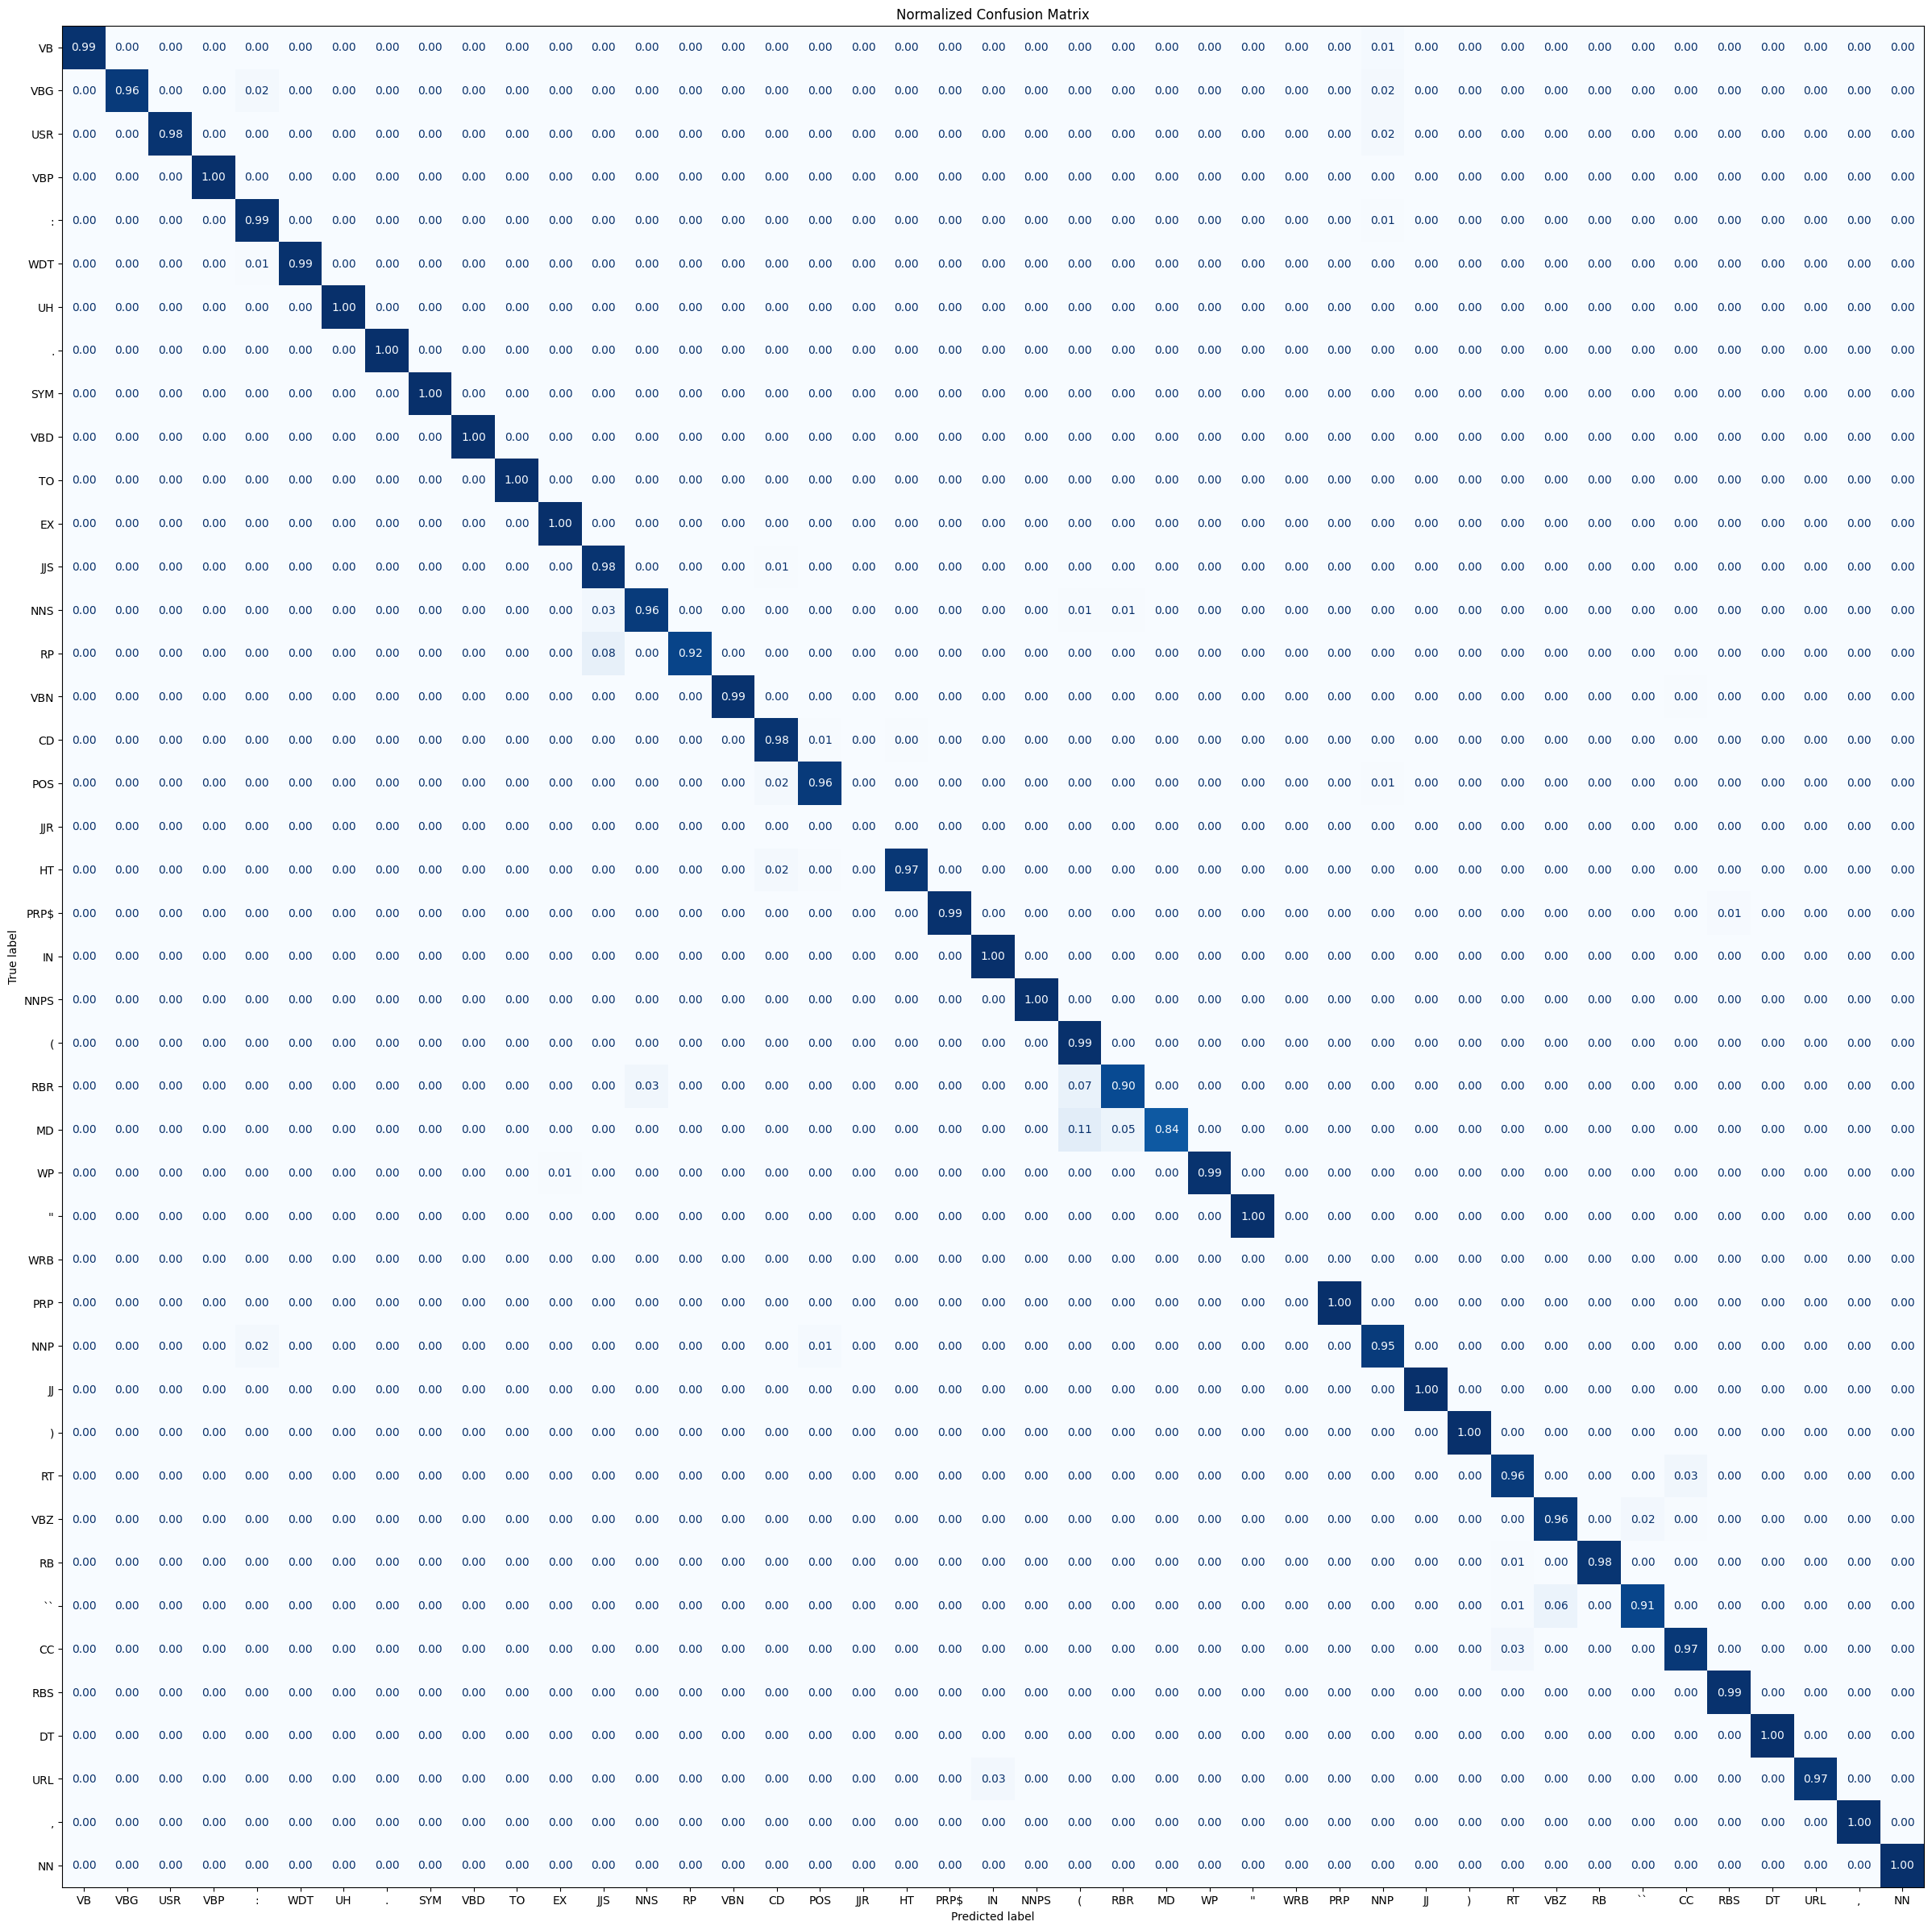

In [33]:
eval_token_list = list(set(eval_df_tokens['labels']))

plot_confusion_matrix(eval_df_tokens["labels"], eval_df_tokens["predicted_label"],
                      eval_token_list)

#### Define & Call Function to Display Example Token Sequences Along With Labels & Losses

In [30]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        eval_df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield eval_df_tmp

eval_df["total_loss"] = eval_df["loss"].apply(sum)
eval_df_tmp = eval_df.sort_values(by="total_loss", ascending=False).head(3)

pd.set_option('display.max_columns', None)

for sample in get_samples(eval_df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
tokens,Go,cardinal,##s,!,!,!,!,#,game,##2,#,NL,##CS,[SEP]
labels,VB,NNPS,IGN,UH,.,UH,.,HT,IGN,IGN,HT,IGN,IGN,IGN
preds,VB,NNS,NNS,.,UH,.,.,HT,HT,HT,HT,NNP,HT,.
losses,0.03,9.29,0.00,8.61,4.15,5.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
tokens,#,W,##EL,##O,##VE,##IF,##Y,##MU,##SI,##C,##VI,##DE,##O,!,!,.,.,.,#,W,##EL,##O,##VE,##IF,##Y,##MU,##SI,##C,##VI,##DE,##O,!,!,.,.,.,#,W,##EL,##O,##VE,##IF,##Y,##MU,##SI,##C,##VI,##DE,##O,!,!,[SEP]
labels,HT,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,.,UH,.,UH,.,HT,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,.,UH,.,UH,.,HT,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,IGN,.,.,IGN
preds,HT,NNP,NNP,NNP,NNP,NN,NN,NN,NN,NN,NN,NN,NN,.,.,:,:,.,HT,NNP,NNP,NNP,NNP,NN,NN,NN,NN,NN,NN,NN,NN,.,.,:,:,.,HT,NNP,NNP,NNP,NNP,NN,NN,NN,NN,NN,NN,NN,NN,.,.,.
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.75,5.80,4.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.96,5.23,3.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
tokens,The,comments,!,!,!,!,!,!,O,##m,##f,##g,.,I,ca,n,',t,with,this,video,.,I,feel,like,my,heart,is,going,to,jump,and,run,away,[SEP]
labels,DT,NNS,.,.,UH,.,UH,.,UH,IGN,IGN,IGN,.,PRP,MD,RB,IGN,IGN,IN,DT,NN,.,PRP,VBP,IN,PRP$,NN,VBZ,VBG,TO,VB,CC,VB,RB,IGN
preds,DT,NNS,.,UH,.,UH,.,.,UH,UH,UH,UH,.,PRP,MD,RB,RB,RB,IN,DT,NN,.,PRP,VBP,IN,PRP$,NN,VBZ,VBG,TO,VB,CC,VB,RB,.
losses,0.00,0.00,0.00,5.94,5.39,2.34,3.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Notes & Other Takeaways From This Project

****
- Normally, I like to include some nice visualizations, which I (unfortunately) did not do with this project. Because I wanted to focus on the main part of the project (for this project and many others), I forewent the visualizations. I intend on completed some as an acillary project after completing the currently list of projects that I have.

- This model struggled to identify (any) 'JJR' and 'WRB' tokens in the error analysis. For 'JJR' tokens, this makes sense because there were only 140 'JJR' samples. On the other hand there were 624 samples of 'WRB' tokens.

- The model also struggled to accurately identify 'RBR' and 'MD' tokens in the error analysis. It makes sense that this model performed poorly handling 'RBR' tokens as there were only 28 samples, but the same cannot be said about 'MD' tokens as there were 1027 'MD' tokens.

- The original metrics from the model stuggled to accurately identify '$', 'nnps', 'sym', and 'fw' tokens. This just cements my next comment even more. 

- I was hesitant to subclass the trainer to handle class imbalance since there were 51 classes; however, given the results, I have rethought that and I will fine-tune a version of this model with a subclassed trainer.

****

### Citations

- Model Checkpoint

    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset

    > @inproceedings{derczynski2013twitter, title={Twitter part-of-speech tagging for all: Overcoming sparse and noisy data}, author={Derczynski, Leon and Ritter, Alan and Clark, Sam and Bontcheva, Kalina}, booktitle={Proceedings of the international conference recent advances in natural language ranlp 2013}, pages={198--206}, year={2013}}

- Metric (PosEval)

    > @article{scikit-learn, title={Scikit-learn: Machine Learning in {P}ython}, author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V. and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P. and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.}, journal={Journal of Machine Learning Research}, volume={12}, pages={2825--2830}, year={2011}}